<h1 align="center" style="color:brown;font-size:300%">Building Dr Krupa's Botany Model</h1>


<div style = 'border : 3px solid non; background-color:#f2f2f2 ; ;padding:10px'>


* **1. Why CNN?**

  - CNN (Convolutional Neural Network) is a deep learning-based method that is used for driver behavior detection. CNN is a type of neural network that is designed to recognize patterns in images and videos. CNNs are particularly useful for image classification tasks because they can automatically learn to detect features such as edges, corners, and shapes in images. In driver behavior detection, CNNs are used to analyze video footage of drivers and identify patterns of behavior that may indicate unsafe driving practices. 
   
   
* **2. Significance**
    
  - Data behavior detection is important because it helps to identify potential cybersecurity threats by tracking user behavior and data access activities. By analyzing both user behavior and data access activities, a behavior analytics tool can create a contextual behavior baseline to help discern behaviors that are normal from those that are not and accurately identify critical data threats.
  

In [5]:
!pip install -q tensorflowjs

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.9.0 requires keras-core, which is not installed.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requir

In [143]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, Input, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflowjs as tfjs
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

# IMAGE CLUSTERING USING CNN TO IDENTIFY FEATURES THAT ARE NOT YET IDENTIFIED

In [166]:
import pandas as pd
from sklearn.cluster import KMeans
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.read_csv('/kaggle/input/cat2files/4-mds/flower_labels.csv')

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(df, directory='/kaggle/input/cat2files/4-mds', x_col='file', y_col='label',
                                        target_size=(64, 64), batch_size=32, class_mode='raw')

# Modify ResNet50 to accept 64x64 images
input_layer = Input(shape=(64, 64, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer, pooling='avg')

feature_extractor = Model(inputs=resnet.input, outputs=resnet.output)

features = feature_extractor.predict(train_gen, verbose=1)

# Perform KMeans clustering (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features)

df['cluster'] = clusters

df.to_csv('resnet.csv', index=False)

print("Cluster labels appended and saved to resnet.csv")


Found 210 validated image filenames.
7/7 [==============================] - 3s 186ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels appended and saved to flower_labels_with_resnet_clusters_64x64.csv


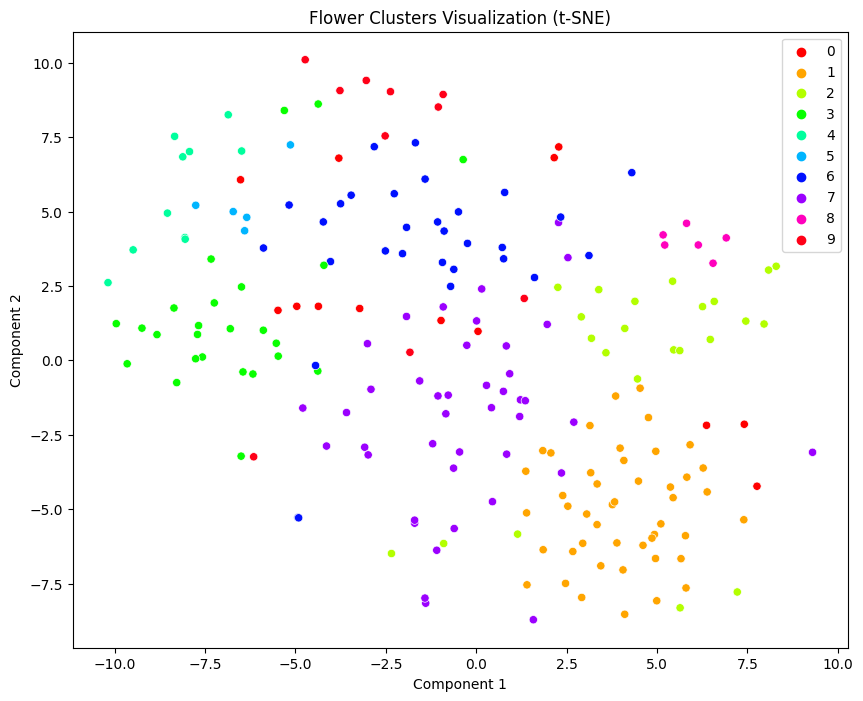

In [185]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce the dimensionality of the features to 2D using PCA or t-SNE
# PCA
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features)

# Or t-SNE (tends to give better separation in 2D)
tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(features)

# Visualize the clusters using PCA or t-SNE
plt.figure(figsize=(10, 8))

# Use seaborn to make it prettier
sns.scatterplot(x=reduced_features_tsne[:, 0], y=reduced_features_tsne[:, 1], hue=kmeans.labels_, 
                palette=sns.color_palette("hsv", as_cmap=True), legend='full')

plt.title('Flower Clusters Visualization (t-SNE)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


# Data preprocessing

In [234]:
# Read in Y labels from CSV
label_csv = '/kaggle/working/flower_labels_with_resnet_clusters_64x64.csv'

# label_csv = '/kaggle/input/cat2files/4-mds/flower_labels.csv'
df_Y = pd.read_csv(label_csv)
df_Y.head()

,file,label,cluster
0,0001.png,0,6
1,0002.png,0,3
2,0003.png,2,1
3,0004.png,0,0
4,0005.png,0,1


# Read images and write with label to arrays

In [236]:
images_path = "/kaggle/input/cat2files/4-mds"
images = []
labels = []
image_files = os.listdir(images_path)
image_files.sort()

for image_path in image_files:
    image = cv.imread(os.path.join(images_path, image_path)).astype('float32') # Read image as a float32 object
    image = cv.resize(image, (64, 64)) # Resize to smaller size for faster train time
#     image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Convert to greyscale for faster train time
    image /= 255.0 # Normalise data
    
    label_index = (image_path) # Get index into df_Y
    print(label_index)
    label = df_Y[df_Y['file'] == label_index].label.values[0] # Get label value
    
    # Write into arrays
    images.append(image)
    labels.append(label)

0001.png
0002.png
0003.png
0004.png
0005.png
0006.png
0007.png
0008.png
0009.png
0010.png
0011.png
0012.png
0013.png
0014.png
0015.png
0016.png
0017.png
0018.png
0019.png
0020.png
0021.png
0022.png
0023.png
0024.png
0025.png
0026.png
0027.png
0028.png
0029.png
0030.png
0031.png
0032.png
0033.png
0034.png
0035.png
0036.png
0037.png
0038.png
0039.png
0040.png
0041.png
0042.png
0043.png
0044.png
0045.png
0046.png
0047.png
0048.png
0049.png
0050.png
0051.png
0052.png
0053.png
0054.png
0055.png
0056.png
0057.png
0058.png
0059.png
0060.png
0061.png
0062.png
0063.png
0064.png
0065.png
0066.png
0067.png
0068.png
0069.png
0070.png
0071.png
0072.png
0073.png
0074.png
0075.png
0076.png
0077.png
0078.png
0079.png
0080.png
0081.png
0082.png
0083.png
0084.png
0085.png
0086.png
0087.png
0088.png
0089.png
0090.png
0091.png
0092.png
0093.png
0094.png
0095.png
0096.png
0097.png
0098.png
0099.png
0100.png
0101.png
0102.png
0103.png
0104.png
0105.png
0106.png
0107.png
0108.png
0109.png
0110.png
0111.png
0

AttributeError: 'NoneType' object has no attribute 'astype'

In [237]:
# Convert to np arrays

images = np.array(images)
labels = np.array(labels)

In [238]:
images[0].shape


(64, 64, 3)

# Let us visualise the count for each class

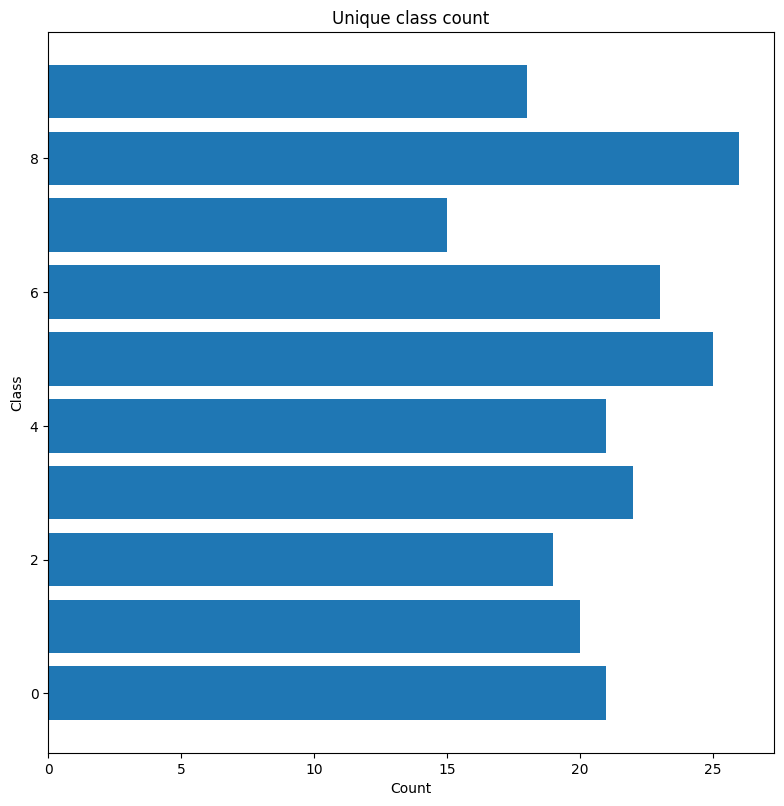

In [239]:
unique_class, class_count = np.unique(labels, return_counts=True)

plt.figure(figsize=(8,8))
plt.barh(unique_class, class_count)
plt.tight_layout(pad=2.0)
plt.title("Unique class count")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

# Add greyscale dimension for cnn

In [207]:
images = np.expand_dims(images, axis=-1) 

# One hot encode the labels

In [240]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [241]:

decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

# Plot 9 random images for visualisation

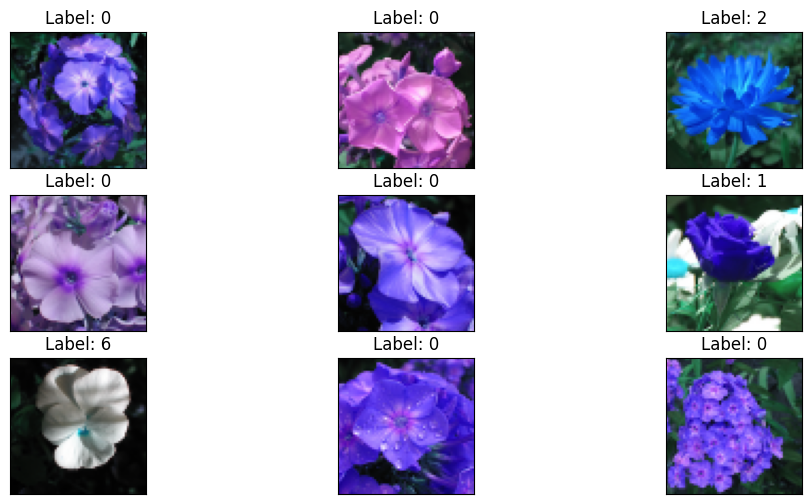

In [242]:
def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

# Randomly shuffle of the data

In [243]:
images, labels = shuffle(images, labels, random_state=0)

# Split the data into train, test and validation sets (147, 30, 30)

In [244]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

# Define augmentation generator for data augmentation

In [246]:
datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range= 0.2, 
    shear_range=0.2,               
    fill_mode='nearest',        
)

In [247]:
# Load augmented data into arrays

augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):
    image_expanded = np.expand_dims(X_train[i], axis=0)  
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    augmented_arr_X.extend(augmented_images)  
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation) 

In [248]:
# Set augmented data up for training

X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [249]:
# Shuffle again

X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

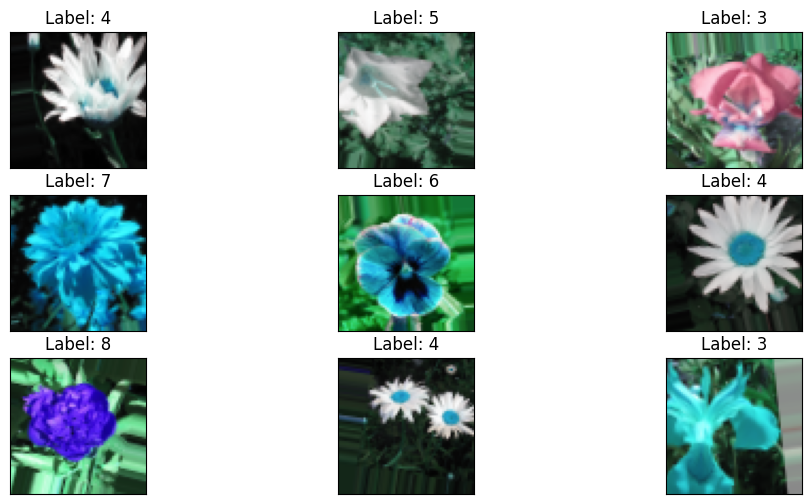

In [250]:
# Display augmented images

display_images(3, 3, X_train, Y_train, decoder)

In [223]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(512, (5, 5), activation='leaky_relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='leaky_relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(1024, activation='relu'),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(256, activation='sigmoid'),
    
    Dense(10, activation='softmax')
])

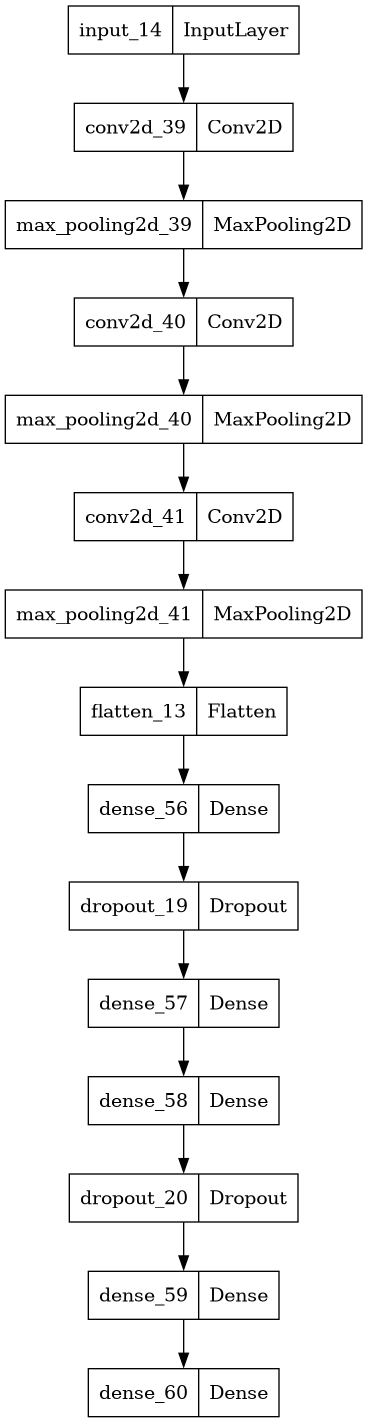

In [224]:
from tensorflow.keras import layers, utils
utils.plot_model(model)

In [225]:
# Visualise model summary

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 60, 60, 512)       13312     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 30, 30, 512)       0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 14, 14, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 12, 12, 256)       590080    
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 6, 6, 256)       

In [226]:
# Compile and train the model

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val,Y_val))

Epoch 1/20
46/46 [==============================] - 4s 30ms/step - loss: 2.3424 - accuracy: 0.1224 - val_loss: 2.3254 - val_accuracy: 0.0968
Epoch 2/20
46/46 [==============================] - 1s 24ms/step - loss: 2.3047 - accuracy: 0.1197 - val_loss: 2.4290 - val_accuracy: 0.0645
Epoch 3/20
46/46 [==============================] - 1s 24ms/step - loss: 2.3017 - accuracy: 0.1293 - val_loss: 2.3712 - val_accuracy: 0.1613
Epoch 4/20
46/46 [==============================] - 1s 24ms/step - loss: 2.3136 - accuracy: 0.1347 - val_loss: 2.3980 - val_accuracy: 0.0645
Epoch 5/20
46/46 [==============================] - 1s 24ms/step - loss: 2.3136 - accuracy: 0.1401 - val_loss: 2.4113 - val_accuracy: 0.0645
Epoch 6/20
46/46 [==============================] - 1s 24ms/step - loss: 2.3000 - accuracy: 0.1197 - val_loss: 2.3914 - val_accuracy: 0.1290
Epoch 7/20
46/46 [==============================] - 1s 24ms/step - loss: 2.2714 - accuracy: 0.1361 - val_loss: 2.2077 - val_accuracy: 0.0968
Epoch 8/20
46

In [258]:
# Train and validation accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

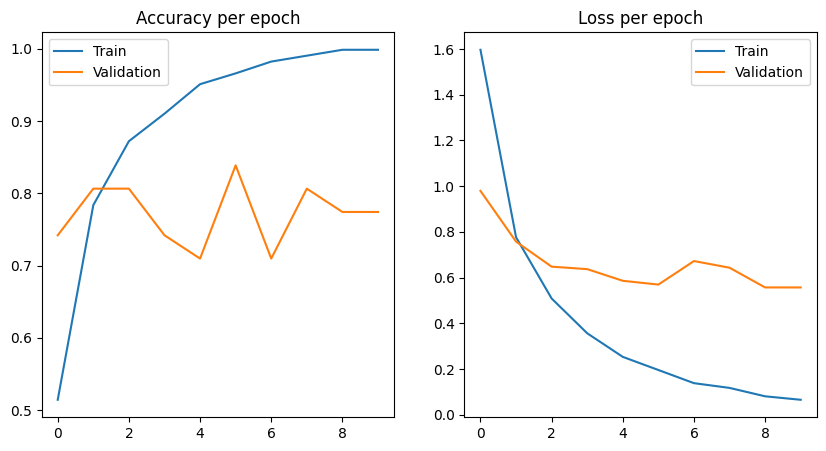

In [259]:
# Plot the accuracy and loss

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Plot accuracy
axes[0].plot(train_accuracy)
axes[0].plot(validation_accuracy)
axes[0].legend(['Train', 'Validation'])
axes[0].set_title("Accuracy per epoch")

# Plot loss
axes[1].plot(train_loss)
axes[1].plot(validation_loss)
axes[1].legend(['Train', 'Validation'])
axes[1].set_title("Loss per epoch")

plt.plot()

In [260]:
# Get test predictions

Y_pred = model.predict(X_test)

1/1 [==============================] - 0s 143ms/step


In [261]:
# Find accuracy of the model

y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7188


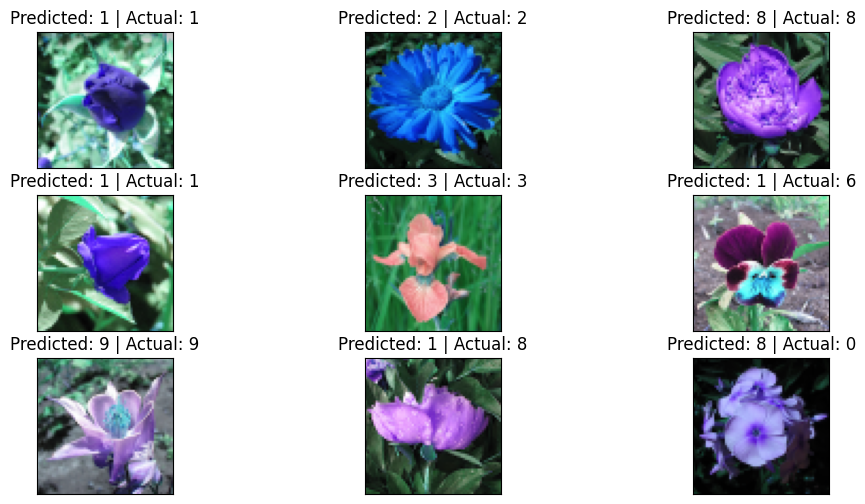

In [262]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Predicted: {decoder[y_pred_classes[i]]} | Actual: {decoder[y_true[i]]}")

# Precision Recall and F1 SCORE

In [263]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1-score: {f1:.4f}')

report = classification_report(y_true, y_pred_classes)
print(report)


Accuracy: 0.7188
Precision: 0.7812
Recall: 0.7188
F1-score: 0.7171
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.60      0.60      0.60         5
           2       0.75      0.75      0.75         4
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         5
           5       1.00      0.50      0.67         2
           6       1.00      0.33      0.50         3
           7       1.00      1.00      1.00         3
           8       0.50      0.75      0.60         4
           9       1.00      0.50      0.67         2

    accuracy                           0.72        32
   macro avg       0.78      0.71      0.70        32
weighted avg       0.78      0.72      0.72        32



# CONFUSION MATRIX FOR TESTING DATA

Confusion Matrix:
[[2 0 0 0 0 0 0 0 1 0]
 [0 3 0 1 0 0 0 0 1 0]
 [0 0 3 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 1 0 0 0 0 0 0 3 0]
 [0 0 1 0 0 0 0 0 0 1]]


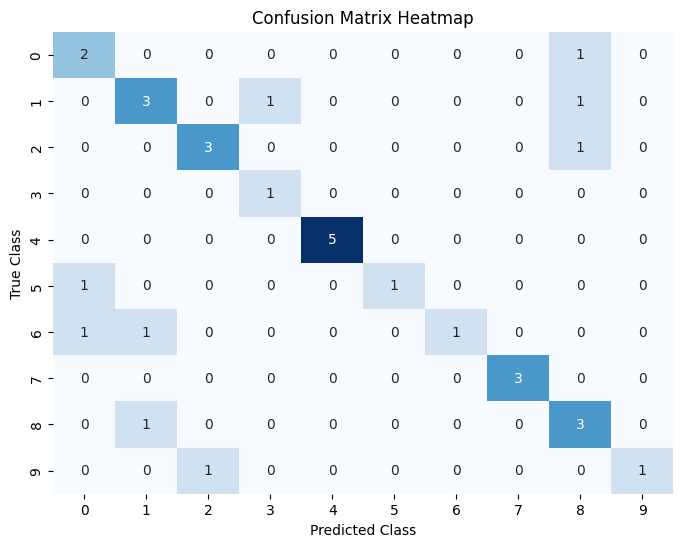

In [264]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


# VGG

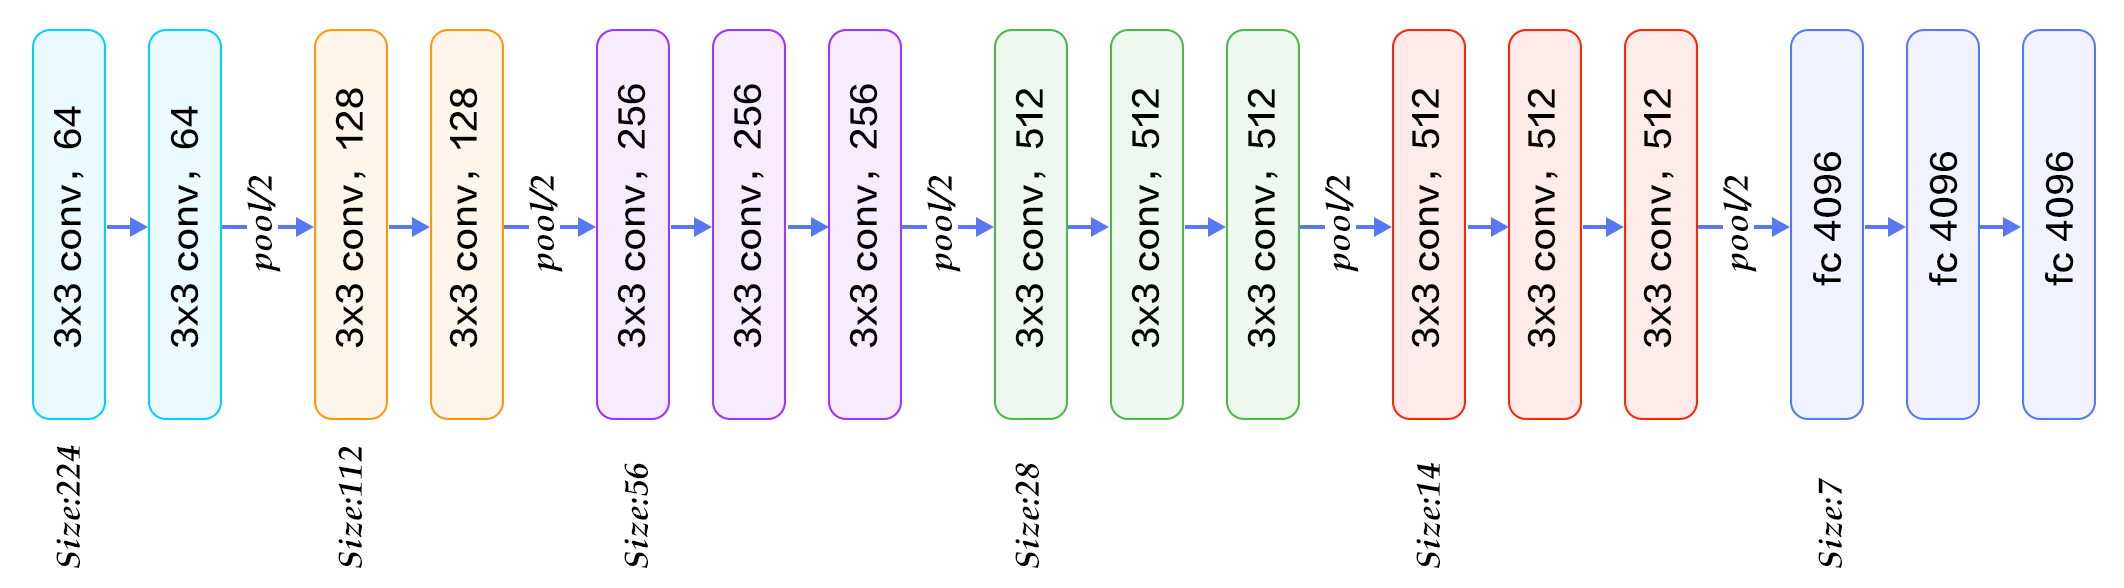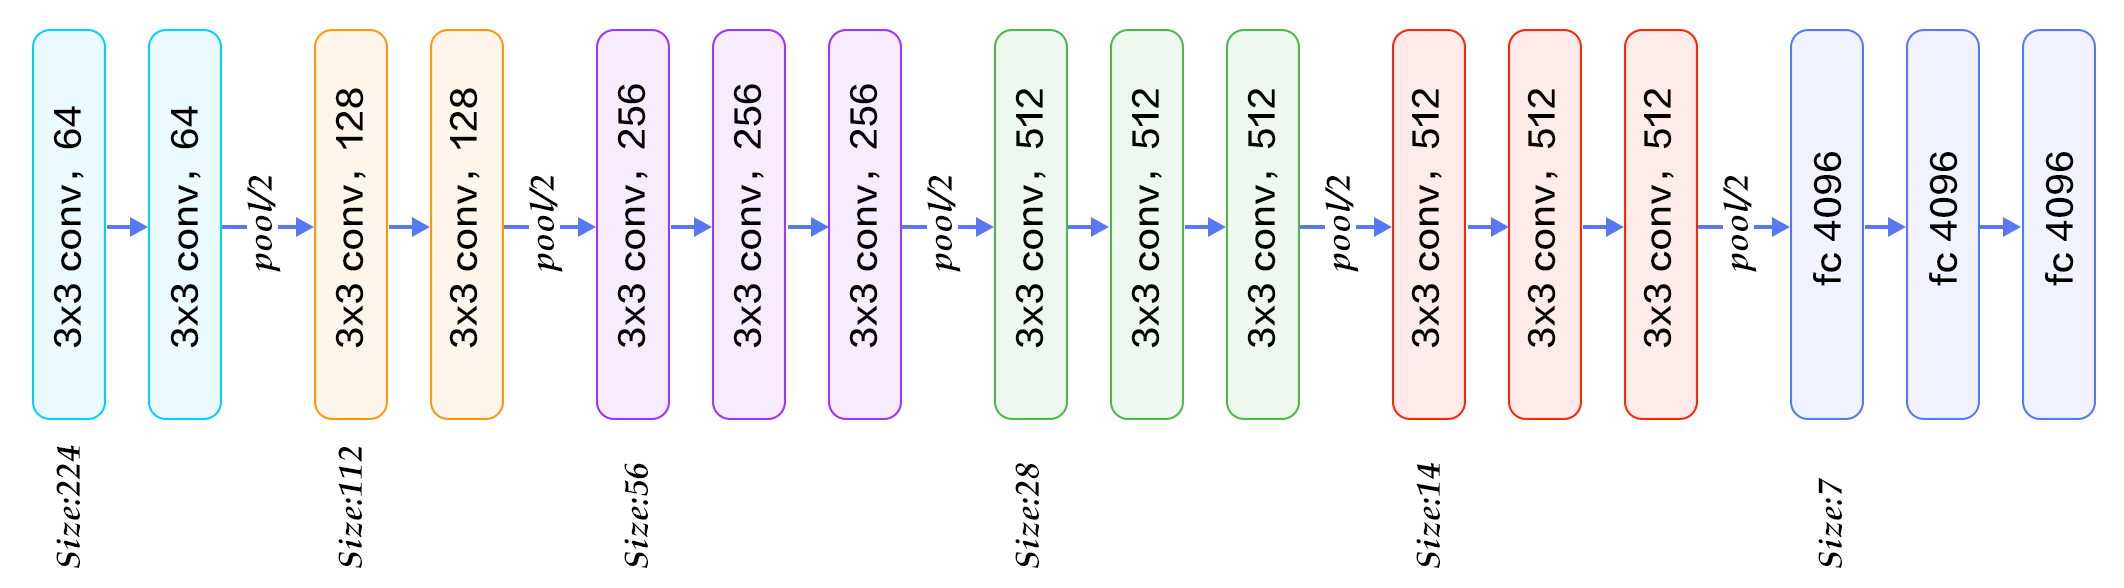

In [257]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_val,Y_val))

Epoch 1/10
46/46 [==============================] - 2s 19ms/step - loss: 1.5965 - accuracy: 0.5143 - val_loss: 0.9794 - val_accuracy: 0.7419
Epoch 2/10
46/46 [==============================] - 1s 11ms/step - loss: 0.7767 - accuracy: 0.7837 - val_loss: 0.7576 - val_accuracy: 0.8065
Epoch 3/10
46/46 [==============================] - 1s 12ms/step - loss: 0.5087 - accuracy: 0.8721 - val_loss: 0.6480 - val_accuracy: 0.8065
Epoch 4/10
46/46 [==============================] - 1s 11ms/step - loss: 0.3567 - accuracy: 0.9102 - val_loss: 0.6372 - val_accuracy: 0.7419
Epoch 5/10
46/46 [==============================] - 1s 12ms/step - loss: 0.2534 - accuracy: 0.9510 - val_loss: 0.5861 - val_accuracy: 0.7097
Epoch 6/10
46/46 [==============================] - 1s 11ms/step - loss: 0.1960 - accuracy: 0.9660 - val_loss: 0.5696 - val_accuracy: 0.8387
Epoch 7/10
46/46 [==============================] - 1s 12ms/step - loss: 0.1385 - accuracy: 0.9823 - val_loss: 0.6725 - val_accuracy: 0.7097
Epoch 8/10
46

# As we can see using the VGG network can tweak the accuracy to a large extent especially the improvement in the test accuracy.

In [265]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_9  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_67 (Dense)            (None, 512)               262656    
                                                                 
 dense_68 (Dense)            (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
